In [1]:
%load_ext autoreload

%autoreload 2

In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from validation.metrics import OME, MSE
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, PowerTransformer
from MODELS.ViscNN import create_ViscNN, create_ViscNN_concat, create_ViscNN_phys, above_Mcr, Mcr_gpr_train, predict_all_cv, create_ViscNN_concat_HP
from validation.tests import viscNN_LC, crossval_NN, Mw_extrapolation, Mw_test, evaluate_model, crossval_compare, shear_extrapolation, shear_test
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs
import keras.backend as K
import keras
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data = pd.read_excel('Data/full_data_2022-01-10.xlsx')

In [128]:
data

,INDEX,SAMPLE_ID,SMILES,Polymer,Mn,Mw,PDI,PDI (zw),Temperature,Shear_Rate,...,PID 1,PID 2,coPID,Weight 1,Weight 2,Frequency,INDEX.1,ZERO_SHEAR,SHEAR,log_Shear_Rate
0,0,1.0,[*]CC([*])C,poly(prop-1-ene),2600.000000,3.591065,1.50,NaN,200.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000
1,1,1.0,[*]CC([*])C,poly(prop-1-ene),7834.101382,4.230449,2.17,NaN,200.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000
2,2,1.0,[*]CC([*])C,poly(prop-1-ene),31981.981982,4.851258,2.22,NaN,200.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000
3,3,1.0,[*]CC([*])C,poly(prop-1-ene),43829.787234,5.012837,2.35,NaN,200.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000
4,4,1.0,[*]CC([*])C,poly(prop-1-ene),75757.575758,5.397940,3.30,NaN,200.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,1840,NaN,"[*]CC([*])C, [*]CCCCCC(=O)N[*]","poly(prop-1-ene), poly(hexano-6-lactam)",NaN,5.143795,NaN,NaN,260.0,983.185240,...,NaN,NaN,NaN,0.75,0.25,NaN,NaN,0,1,2.992635
1656,1841,NaN,"[*]CC([*])C, [*]CCCCCC(=O)N[*]","poly(prop-1-ene), poly(hexano-6-lactam)",NaN,5.143795,NaN,NaN,260.0,1966.575688,...,NaN,NaN,NaN,0.75,0.25,NaN,NaN,0,1,3.293711
1657,1842,NaN,"[*]CC([*])C, [*]CCCCCC(=O)N[*]","poly(prop-1-ene), poly(hexano-6-lactam)",NaN,5.143795,NaN,NaN,260.0,4890.706373,...,NaN,NaN,NaN,0.75,0.25,NaN,NaN,0,1,3.689372
1658,1843,NaN,"[*]CC([*])C, [*]CCCCCC(=O)N[*]","poly(prop-1-ene), poly(hexano-6-lactam)",NaN,5.143795,NaN,NaN,260.0,9812.487056,...,NaN,NaN,NaN,0.75,0.25,NaN,NaN,0,1,3.991779


In [5]:
extrap, PL_data, extrap_samps = Mw_extrapolation(data.copy(), 10)
#data = pd.concat([data, extrap], ignore_index = True).reset_index(drop = True)

Found Zero Shear Samples
Found LOBF for samples
Generating sample...0
Generating sample...1
Generating sample...2
Generating sample...3
Generating sample...4
Generating sample...5
Generating sample...6
Generating sample...7
Generating sample...8
Generating sample...9


In [6]:
shear_samps = shear_extrapolation(data.copy())

In [21]:
OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)
len(OG_fp)

217

In [8]:
do_pca = False
if do_pca:
    data, fp_cols, pca = fp_PCA(data, 17, cols = OG_fp)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = OG_fp
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

In [9]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
        #data = data.drop([i])

In [10]:
#cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols + ['Polymer', 'SHEAR', 'ZERO_SHEAR', 'log_Shear_Rate']].dropna(subset = ['Mw', 'Shear_Rate'])
#X_tot = np.array(filtered_data.filter(fp_cols + ['SHEAR', 'ZERO_SHEAR']))
X_tot = np.array(filtered_data.filter(fp_cols))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [59]:
logMw = np.array(filtered_data['Mw']).reshape((tot_samples,1))
log_shear = np.array(filtered_data['log_Shear_Rate']).reshape((tot_samples,1))
shear = np.array(filtered_data['Shear_Rate']).reshape((tot_samples,1))
Temp = np.array(filtered_data['Temperature']).reshape((tot_samples,1))
scaler = MinMaxScaler(copy = False)
scaler.fit(X_tot).transform(X_tot)
#y_scaler = MinMaxScaler(copy = False)
#y_scaler.fit(Y_tot).transform(Y_tot);
#S_scaler = MaxAbsScaler().fit(log_shear)
#log_shear = S_scaler.transform(log_shear)
T_scaler = MinMaxScaler().fit(Temp)
Temp = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
logMw = M_scaler.transform(logMw);
#S_trans = PowerTransformer(standardize = False).fit(shear)
#S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
S_scaler = MinMaxScaler().fit((shear))
#shear = S_scaler.transform(S_trans.transform(shear))
shear = S_scaler.transform((shear))
#gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)

In [85]:
XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind = train_test_split(X_tot, Y_tot,logMw, shear, Temp, range(tot_samples), test_size= 0.10)

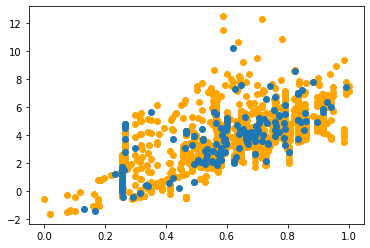

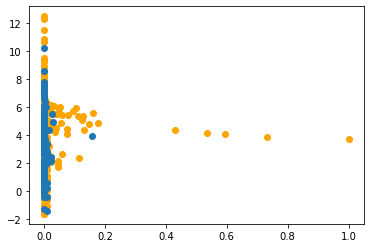

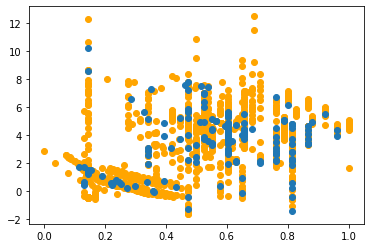

In [61]:
plt.scatter(M, yy, c = 'orange')
plt.scatter(M_test, y_test)

plt.figure()
plt.scatter(S, yy, c = 'orange')
plt.scatter(S_test, y_test)

plt.figure()
plt.scatter(T, yy, c = 'orange')
plt.scatter(T_test, y_test)

In [88]:
models, history, gpr_models, gp_cv  = crossval_compare([create_ViscNN_concat], XX, yy, M=M, S=S, T=T, S_trans = S_trans, S_scaler = S_scaler, M_scaler = M_scaler, verbose = 1, gpr_model = create_GPR, epochs = 600)

Trained fold 1 ...
CV Error create_ViscNN_concat: 0.38235536217689514
CV Error GPR: tf.Tensor(0.31818622, shape=(), dtype=float32)
Trained fold 2 ...
CV Error create_ViscNN_concat: 0.48166942596435547
CV Error GPR: tf.Tensor(0.36089694, shape=(), dtype=float32)
Trained fold 3 ...
CV Error create_ViscNN_concat: 0.4040059447288513
CV Error GPR: tf.Tensor(0.31429422, shape=(), dtype=float32)
Trained fold 4 ...
CV Error create_ViscNN_concat: 0.4261552691459656
CV Error GPR: tf.Tensor(0.30479234, shape=(), dtype=float32)
Trained fold 5 ...
CV Error create_ViscNN_concat: 0.4432065784931183
CV Error GPR: tf.Tensor(0.36122975, shape=(), dtype=float32)
Trained fold 6 ...
CV Error create_ViscNN_concat: 0.41067469120025635
CV Error GPR: tf.Tensor(0.29660952, shape=(), dtype=float32)
Trained fold 7 ...
CV Error create_ViscNN_concat: 0.4412744641304016
CV Error GPR: tf.Tensor(0.34893438, shape=(), dtype=float32)
Trained fold 8 ...
CV Error create_ViscNN_concat: 0.39605289697647095
CV Error GPR: tf.

In [63]:
model_num = 8

Test OME:0.36216846


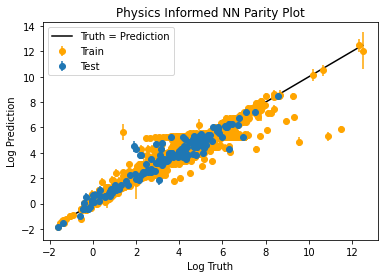

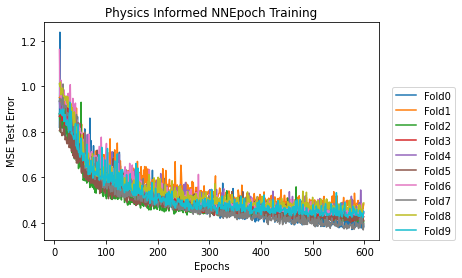

In [123]:
m_P = models[0][model_num]

test_pred, test_var = predict_all_cv(models[0],[X_test, M_test, S_test, T_test])
train_pred, train_var = predict_all_cv(models[0],[XX, M, S, T])
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Physics Informed NN Parity Plot')
val_epochs(history[0], name = 'Physics Informed NN')

print("Test OME:" + str(OME(np.array(test_pred),[y[0] for y in y_test]).numpy()))

In [127]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
train_df[train_df['BAD_PRED'] == True].sort_index().to_excel('NP_Bad_pred_1_12_2022.xlsx')

0.4894996087924004


In [411]:
m_P.summary()

Model: "model_148"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_641 (InputLayer)          [(None, 217)]        0                                            
__________________________________________________________________________________________________
input_643 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_645 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_238 (Concatenate)   (None, 219)          0           input_641[0][0]                  
                                                                 input_643[0][0]          

In [86]:
m_NP = models[1][model_num]
# test_pred =  m_NP.predict([X_test, M_test, S_test, T_test, gr_Mcr_test])
# train_pred = m_NP.predict([XX, M, S, T, gr_Mcr])
test_pred, test_var = predict_all_cv(models[1],[X_test, M_test, S_test, T_test, gr_Mcr_test])
train_pred, train_var = predict_all_cv(models[1],[XX, M, S, T, gr_Mcr])
#plt.scatter(yy, train_pred, c = 'orange')
#plt.scatter(y_test, test_pred)
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')


plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Non-Physics NN Parity Plot')
val_epochs(history[1], name = 'Non-Physics NN')

print("Test OME:" + str(OME(test_pred, [y[0] for y in y_test]).numpy()))


IndexError: list index out of range

In [90]:
#gpr_model = train_GPR(XX, yy, M, S, T)
gpr_model = gpr_models[model_num]

Test MSE:0.2223754220322901
Test OME:tf.Tensor(0.27996427, shape=(), dtype=float32)
(160,)


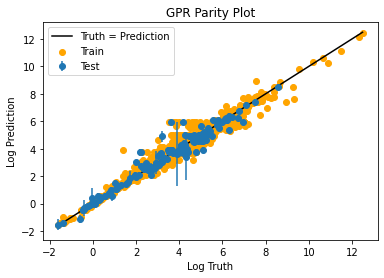

In [92]:
gpr_model = gpr_models[model_num] 
X_ = np.concatenate((X_test, M_test, S_test, T_test), axis = 1)
X_train = np.concatenate((XX, M, S, T), axis = 1)
test_pred, var = gpr_model.predict_y(X_)
## generate 10 samples from posterior
error =  [i[0] for i in np.array(var).tolist()]
print("Test MSE:" + str(MSE(test_pred, y_test)))
print("Test OME:" + str(OME(tf.cast(test_pred, tf.float32), y_test)))

high_var_test = np.where(np.array(var) > 10)
test_pred = np.delete(np.array(test_pred), high_var_test)
print(test_pred.shape)
y_test_new = np.delete(np.array(y_test), high_var_test)
var = np.delete(np.array(var), high_var_test)
# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
train_pred, var_train = gpr_model.predict_y(X_train)
plt.scatter(yy, train_pred, c = 'orange')
plt.errorbar(y_test_new, test_pred, var, fmt = 'o')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.legend(['Truth = Prediction', 'Train','Test'])
plt.title('GPR Parity Plot')
plt.show()

In [419]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]
test_df.reset_index().loc[error.index(max(error))]

0.4709271519435972


index                  658
afp_C4_C4_C4      0.151515
afp_C4_C4_H1      0.363636
afp_H1_C4_H1      0.151515
bfp_267                0.0
                    ...   
ZERO_SHEAR               1
log_Shear_Rate         0.0
Y_pred            0.012694
Error             1.222835
BAD_PRED              True
Name: 75, Length: 229, dtype: object

In [67]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
train_df[train_df['BAD_PRED'] == True]

0.34246501152543185


,afp_C4_C4_C4,afp_C4_C4_H1,afp_H1_C4_H1,bfp_267,bfp_282,bfp_289,bfp_304,bfp_315,bfp_334,bfp_349,...,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,log_Shear_Rate,Y_pred,Error,BAD_PRED
1544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493218,0.570096,...,260.0,935.307371,2.139073,"Poly(hexano-6-lactam), PPTA",1,0,2.970954,2.845784,0.706711,True
261,0.266667,0.466667,0.466667,0.533333,0.000000,0.200000,1.400000,0.000000,0.533333,0.533333,...,220.0,89.526571,4.423077,poly(methyl methacrylate),1,0,1.951952,3.929518,0.493559,True
1165,0.149429,0.448286,0.074714,0.000000,0.298857,0.224143,0.896571,0.149429,0.448286,0.489143,...,200.0,0.097696,4.552494,"polystyrene, polyacrylonitrile",1,0,-1.010123,4.170946,0.381547,True
1089,0.134643,0.403929,0.067321,0.000000,0.269286,0.201964,0.807857,0.134643,0.403929,0.495714,...,170.0,0.000000,3.214844,"polystyrene, polyacrylonitrile",0,1,0.000000,3.880512,0.665668,True
194,0.125000,0.375000,0.062500,0.000000,0.250000,0.187500,0.750000,0.125000,0.375000,0.500000,...,200.0,548.441658,2.209302,polystyrene,1,0,2.739130,2.872448,0.663145,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.181571,0.544714,0.090786,0.000000,0.363143,0.272357,1.089429,0.181571,0.544714,0.474857,...,200.0,0.390965,5.426735,"polystyrene, polyacrylonitrile",1,0,-0.407862,4.978222,0.448514,True
875,0.151515,0.484848,0.181818,0.000000,0.000000,0.545455,0.636364,0.000000,0.545455,0.363636,...,205.0,0.000000,3.399674,"poly[(2,2,3,3,4,4-hexafluoropentane-1,5-diol)-...",0,1,0.000000,3.810134,0.410461,True
183,0.333333,0.666667,0.166667,0.000000,0.000000,0.500000,1.000000,0.000000,0.666667,0.333333,...,210.0,0.000000,5.000000,poly(vinylidene fluoride),0,1,0.000000,5.585200,0.585200,True
1329,0.273810,0.821429,0.161905,0.033333,0.547619,0.410714,1.642857,0.273810,0.821429,0.435714,...,220.0,38.940893,3.532110,"polyacrylonitrile, Poly(methyl acrylate)",1,0,1.590406,4.012979,0.480869,True


In [31]:
tuner = kt.Hyperband(create_ViscNN_concat_HP, objective='val_loss',
                     max_epochs=20,
                     factor=3, project_name = 'create_ViscNN_concat2')

tuner.search([XX, M, S, T], yy,
             validation_data= ([X_test, M_test, S_test, T_test], y_test),
             epochs=20,
             batch_size = 16,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 30 Complete [00h 00m 06s]
val_loss: 1.279147982597351

Best val_loss So Far: 1.166451096534729
Total elapsed time: 00h 01m 17s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner.get_best_hyperparameters(num_trials = 1)[0].values


{'layer_1': 180,
 'layer_2': 150,
 'dropout_1': 0.1,
 'dropout_2': 0.0,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '8a713566262e5d11cd6877265c9d63a2'}

In [420]:
k_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('log_k_1').output)
tau_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('tau').output)
alpha_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('alpha').output)
n_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('n').output)
crit_shear_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('crit_shear').output)
layer_name2 = 'zero_shear_visc'
z_shear_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer(layer_name2).output)

In [101]:
#PL_data.head(10)
extrap_tests = Mw_test(PL_data.copy(), samps = [0,1,2,3,4,5,6,7,8,9,10,11,12, 13, 14, 15])

  SAMPLE_ID      Polymer   SMILES  Temperature          Mcr    Log_K1  \
2         6  Linear HDPE  [*]C[*]        150.0  3656.398809 -3.904875   

     Log_K2     Alpha  afp_C4_C4_C4  afp_C4_C4_H1  ...  bfp_244  bfp_290  \
2 -13.40241  3.665561      0.333333      1.333333  ...        0        0   

   bfp_456  bfp_46  bfp_47  bfp_55  bfp_79  bfp_210  bfp_482  Shear_Rate  
2        0       0       0       0       0        0        0           0  

[1 rows x 226 columns]


In [118]:
samp_num = 8
XX_ex, OH, M_ex_og,S_ex_og,T_ex,y_ex = extrap_tests[samp_num]['data_in']
print(extrap_tests[samp_num]['tests'])
Mw_ex = extrap_samps[samp_num][0]
log_visc_ex = extrap_samps[samp_num][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform((S_ex_og)) #(S_trans.transform
T_ex = T_scaler.transform(T_ex)

       logMw  Temperature  Shear_Rate      Polymer  afp_C4_C4_C4  \
0   2.000000        160.0           0  polystyrene         0.125   
1   2.102564        160.0           0  polystyrene         0.125   
2   2.205128        160.0           0  polystyrene         0.125   
3   2.307692        160.0           0  polystyrene         0.125   
4   2.410256        160.0           0  polystyrene         0.125   
5   2.512821        160.0           0  polystyrene         0.125   
6   2.615385        160.0           0  polystyrene         0.125   
7   2.717949        160.0           0  polystyrene         0.125   
8   2.820513        160.0           0  polystyrene         0.125   
9   2.923077        160.0           0  polystyrene         0.125   
10  3.025641        160.0           0  polystyrene         0.125   
11  3.128205        160.0           0  polystyrene         0.125   
12  3.230769        160.0           0  polystyrene         0.125   
13  3.333333        160.0           0  polystyre

C:\Users\ayush\Documents\Melt_Viscosity\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Text(0.5, 1.0, 'GPR Extrapolation')

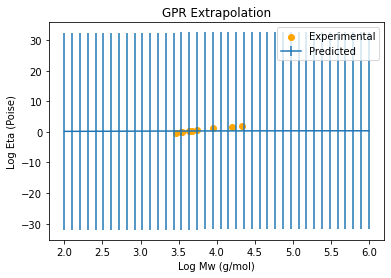

In [119]:
test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex, T_ex), axis = 1))
plt.figure()
plt.xlabel('Log Mw (g/mol)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
#plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
plt.legend(['Experimental','Predicted'])
plt.title('GPR Extrapolation')

In [114]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])

plt.figure()
plt.title('Non-Physics NN Extrapolation')
plt.xlabel('Log Mw (g/mol)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
#plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var)
plt.legend(['Experimental','Predicted'])

IndexError: list index out of range

NameError: name 'k_layer' is not defined

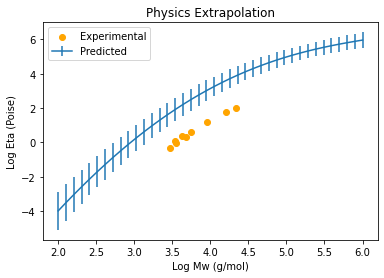

In [120]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
test_pred, test_var = predict_all_cv(models[0],[XX_ex, M_ex, S_ex, T_ex])
plt.figure()
plt.title('Physics Extrapolation')
plt.xlabel('Log Mw (g/mol)')
plt.ylabel('Log Eta (Poise)')
plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var)
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
#plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
plt.legend(['Experimental','Predicted'])
#plt.plot([4,6], [2.5, 2.5+(3.4*2)])
print(k_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(tau_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(alpha_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(n_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))

In [389]:
len( shear_samps['SAMPLE_ID'].values)

3156

In [135]:
samp_num = shear_samps['SAMPLE_ID'].values[100]
s_test = shear_test(shear_samps, samp_num);
XX_ex, M_ex,S_ex,T_ex = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = s_test['known'][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(M_ex)
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(T_ex)
temp_test = True

    SAMPLE_ID                    Polymer             SMILES  Temperature  \
0       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
1       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
2       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
3       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
4       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
5       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
6       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
7       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
8       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
9       269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
10      269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   
11      269.0  poly(p-phenylene sulfide)  [*]Sc1ccc([*])cc1        300.0   

         Mw

C:\Users\ayush\github\Melt_Viscosity_Predictor\validation\tests.py:369: RuntimeWarning: divide by zero encountered in log10
  trial_shear = np.log10(np.array(trial['Shear_Rate'])).reshape(-1,1)
C:\Users\ayush\Documents\Melt_Viscosity\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


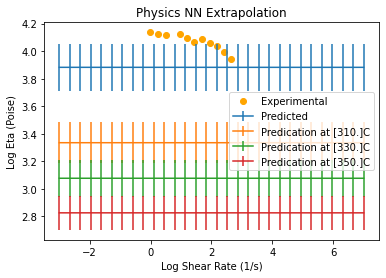

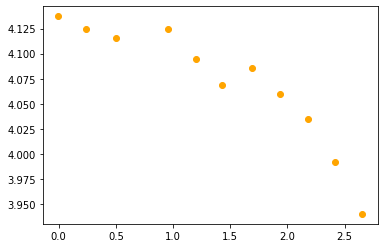

In [138]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var = predict_all_cv(models[0],[XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in np.log10(S_ex)]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[0],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]])])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
#plt.plot(np.log10(S_ex[:-1]), test_pred[:-1])
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Predication at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
     plt.legend(['Experimental','Predicted'])
plt.title('Physics NN Extrapolation')


plt.figure()
plt.scatter(shear_exp, log_visc_exp, c = 'orange')

#print(params_layer([XX_ex, M_ex, S_ex_trans, T_ex]))
#z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex])
#print(crit_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(tau_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(n_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))

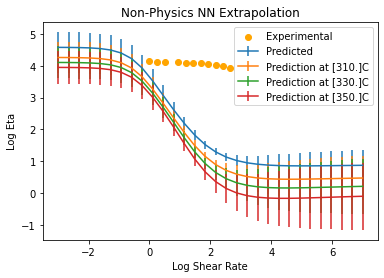

In [510]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var = predict_all_cv(models[1], [XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
shear = [s[0] for s in np.log10(S_ex)]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Non-Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])
#plt.plot(np.log10(S_ex), test_pred)

[17.807659242057355, 17.80765924205733, 17.807659242057277, 17.807659242057163, 17.807659242056914, 17.8076592420564, 17.807659242055394, 17.807659242053724, 17.80765924205186, 17.807659242051994, 17.807659242057575, 17.807659242069843, 17.80765924208618, 17.80765924210284, 17.807659242117435, 17.807659242129205, 17.807659242138296, 17.80765924214519, 17.80765924215038, 17.8076592421543, 17.807659242157285, 17.807659242159577, 17.807659242161353, 17.807659242162746, 17.807659242163847, 17.80765924216473, 17.807659242165435, 17.80765924216601, 17.807659242166483, 17.80765924216687]


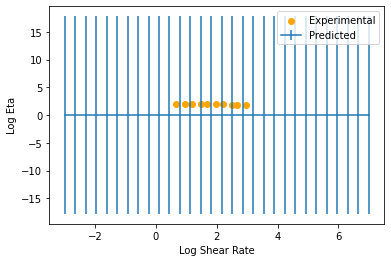

In [483]:
test_pred, test_var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
plt.figure()
plt.errorbar(shear, test_pred, yerr= [i[0] for i in np.array(test_var).tolist()])
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
print([i[0] for i in np.array(test_var).tolist()])
plt.legend(['Experimental','Predicted'])

START TRAINING GPR FOR Mcr

In [94]:
me_data = pd.read_excel('Data/EntanglementMW_fp.xlsx')
fp = me_data[[c for c in me_data.columns if 'fp' in c]]
fp[[c for c in OG_fp if c not in fp]] = 0
fp = fp.drop(columns = [c for c in fp if c not in OG_fp])
y = M_scaler.transform(np.log10(np.array(me_data['Me']*2)).reshape(-1,1))
X_me = scaler.transform((pca.transform(fp[OG_fp]))) if do_pca else scaler.transform(((fp[OG_fp])))

C:\Users\ayush\Documents\Melt_Viscosity\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [95]:
x_me, x_me_test, y_me, y_me_test = train_test_split(X_me, y, test_size = 0.1)

In [96]:
gpr_Mcr = create_GPR(X_me, y)

Text(0.5, 1.0, 'Mcr Prediction GPR - Parity Plot')

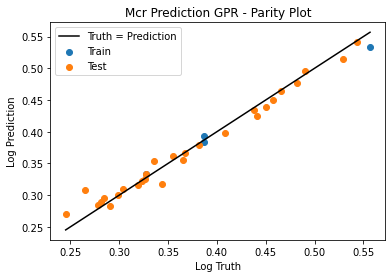

In [99]:
mcr_pred, var = gpr_Mcr.predict_y(x_me_test)
mcr_train_pred, var_train = gpr_Mcr.predict_y(x_me)
plt.scatter(y_me_test, mcr_pred)
plt.scatter(y_me, mcr_train_pred)
plt.plot(np.linspace((min(y)[0]), (max(y)[0]), num = 2),np.linspace((min(y)[0]), (max(y)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Mcr Prediction GPR - Parity Plot')

In [15]:
tf.constant(mcr_pred)

<tf.Tensor: shape=(4, 1), dtype=float64, numpy=
array([[0.36688887],
       [0.42476719],
       [0.42645432],
       [0.34991337]])>

In [16]:
gpr_Mcr.predict_f_compiled = tf.function(
    gpr_Mcr.predict_f, input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)]
)

In [17]:
tf.saved_model.save(gpr_Mcr, 'models')

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [18]:
gpr = tf.saved_model.load('models')

In [ ]:
gpr.predict_y(x_me)

In [37]:
l = []
for i in [0,1,2]:
    l += [[i,i,i]]

In [40]:
np.std(np.array(l), axis = 1)

array([0., 0., 0.])